<a href="https://colab.research.google.com/github/Penk13/fastai/blob/main/BearClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bear Classification**
Source: https://nbviewer.org/github/fastai/fastbook/blob/master/02_production.ipynb

In [51]:
# Install and import fastbook and fastai
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [52]:
# Define three bear types
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    # Create folder bears
    path.mkdir()

    # Create a folder, search for images, and download images from search results for each bear type
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

In [53]:
# Return a list of image paths
fns = get_image_files(path)
fns

(#512) [Path('bears/teddy/ecfbb52a-951b-4567-82ba-cefe2cc69b6a.png'),Path('bears/teddy/86534042-99b7-4b23-ad27-bef48e48df7e.png'),Path('bears/teddy/03884de4-234a-4e3d-a517-aa8af0077d36.jpg'),Path('bears/teddy/94da941f-3bad-4982-ae75-8d6176221d3b.jpg'),Path('bears/teddy/565fa55a-3821-419d-a22a-01506957ee91.jpg'),Path('bears/teddy/99c7748b-489d-41cd-8f84-c929deac318a.jpg'),Path('bears/teddy/2ca90051-c8d9-42fd-8c1d-94329a614b15.jpg'),Path('bears/teddy/8d95a5b0-59a1-49b8-88d3-1cbb2b66183f.jpg'),Path('bears/teddy/11ccd861-e772-466d-9f88-40893e7a0924.jpeg'),Path('bears/teddy/47455beb-aef2-445b-8980-dcce90015a4b.jpg')...]

In [54]:
# Return a list of image paths that can't be loaded/opened
failed = verify_images(fns)
failed

(#0) []

In [55]:
# Remove all the files that can't be loaded/opened
failed.map(Path.unlink)

(#0) []

In [56]:
# Create datablock
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

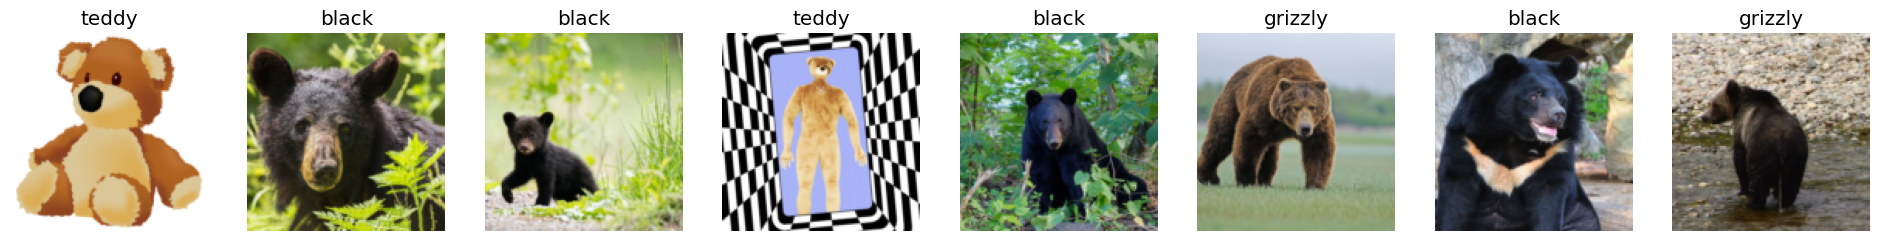

In [57]:
# Enter the data into the datablock
dls = bears.dataloaders(path)

# Show some data from validation set
dls.valid.show_batch(max_n=8, nrows=1)

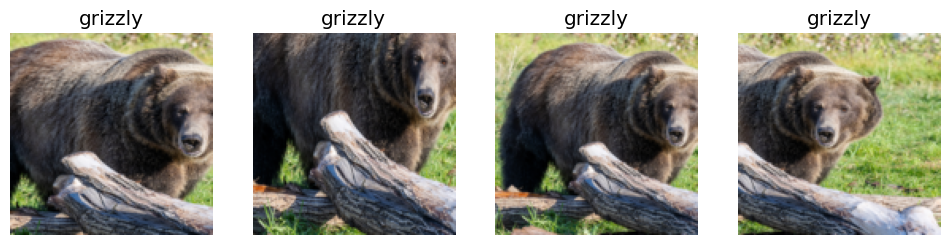

In [58]:
# Modify datablock
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)

# Show some data from training set
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [59]:
# Modify datablock
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [60]:
# Train a model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.304512,0.259270,0.068627,02:09


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.268452,0.234484,0.058824,02:40
1,0.215350,0.199765,0.049020,02:38
2,0.184845,0.200460,0.049020,02:42
3,0.149958,0.199662,0.058824,02:37


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


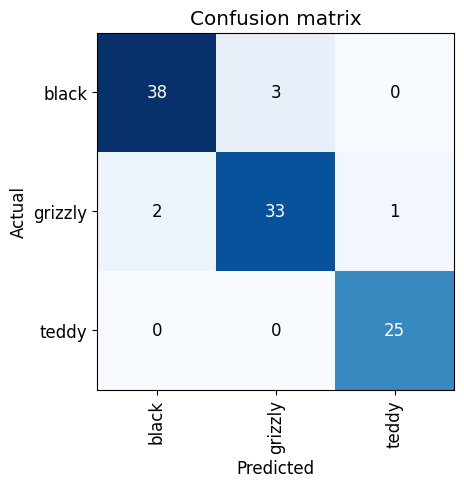

In [61]:
# Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

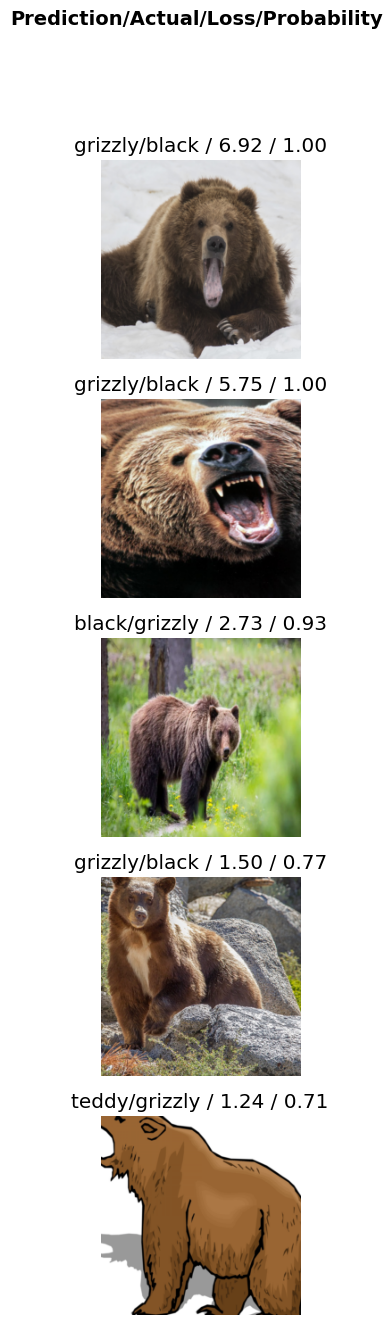

In [62]:
# Show top losses
interp.plot_top_losses(5, nrows=5)

In [63]:
# Create cleaner to clean the data manually using simple GUI
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [64]:
# Delete image according to the label on the cleaner
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# Change label according to the label on the cleaner
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [65]:
# Export the model to pkl file
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [66]:
# Use the model that has been saved on the pkl file before
learn_inf = load_learner(path/'export.pkl')

In [67]:
# Use the model to predict
learn_inf.predict(path/'grizzly.jpg')

('grizzly', tensor(1), tensor([1.7105e-03, 9.9828e-01, 6.1490e-06]))

In [68]:
# See the available category
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']